In [37]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.preprocessing import LabelEncoder

In [2]:
def encoder(df):
    l = LabelEncoder()
    for i in df.select_dtypes(include='object'):
        if df[i].nunique() <= 2:
            df[i] = l.fit_transform(df[i])
    df = pd.get_dummies(df)
    return df

In [27]:
def kde(df, column):
    if column == 'TARGET':
        return
    sns.kdeplot(df[df['TARGET'] == 0][column], color='green')
    sns.kdeplot(df[df['TARGET'] == 1][column], color='red')
    plt.title(column, fontsize=50)

In [25]:
def bar(df, column):
    if column == 'TARGET':
        return
    val = df.groupby(column)['TARGET'].mean()
    sns.barplot(val.index, val.values)
    plt.title(column, fontsize=50)

In [6]:
os.listdir()

['.ipynb_checkpoints',
 'application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'catboost_info',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv',
 'train.csv',
 'train2.csv',
 'train3.csv',
 'Untitled.ipynb',
 'Untitled1.ipynb',
 'Untitled2.ipynb']

In [7]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
bur = pd.read_csv('bureau.csv')
bur_bal = pd.read_csv('bureau_balance.csv')
card_bal = pd.read_csv('credit_card_balance.csv')
column_descr = pd.read_csv('HomeCredit_columns_description.csv')
payments = pd.read_csv('installments_payments.csv')
pos = pd.read_csv('POS_CASH_balance.csv')
prev_appl = pd.read_csv('previous_application.csv')


In [8]:
column_descr

Unnamed: 0                         Table                    Row  \
0             1  application_{train|test}.csv             SK_ID_CURR   
1             2  application_{train|test}.csv                 TARGET   
2             5  application_{train|test}.csv     NAME_CONTRACT_TYPE   
3             6  application_{train|test}.csv            CODE_GENDER   
4             7  application_{train|test}.csv           FLAG_OWN_CAR   
..          ...                           ...                    ...   
214         217     installments_payments.csv  NUM_INSTALMENT_NUMBER   
215         218     installments_payments.csv        DAYS_INSTALMENT   
216         219     installments_payments.csv     DAYS_ENTRY_PAYMENT   
217         220     installments_payments.csv         AMT_INSTALMENT   
218         221     installments_payments.csv            AMT_PAYMENT   

                                           Description  \
0                             ID of loan in our sample   
1    Target variable (1 - client with payment diffi...   
2          Identification if loan is cash or revolving   
3                                 Gender of the client   
4                        Flag if the client owns a car   
..                                                 ...   
214            On which installment we observe payment   
215  When the installment of previous credit was su...   
216  When was the installments of previous credit p...   
217  What was the prescribed installment amount of ...   
218  What the client actually paid on previous cred...   

                                   Special  
0                                      NaN  
1                                      NaN  
2                                      NaN  
3                                      NaN  
4                                      NaN  
..                                     ...  
214                                    NaN  
215  time only relative to the application  
216  time only relative to the application  
217                                    NaN  
218                                    NaN  

[219 rows x 5 columns]

In [9]:
train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20  \
0           24700.5  ...                 0                0                0   
1           35698.5  ...                 0                0                0   
2            6750.0  ...                 0                0                0   
3           29686.5  ...                 0                0                0   
4           21865.5  ...                 0                0                0   
...             ...  ...               ...              ...              ...   
307506      27558.0  ...                 0                0                0   
307507      12001.5  ...                 0                0                0   
307508      29979.0  ...                 0                0                0   
307509      20205.0  ...                 0                0                0   
307510      49117.5  ...                 0                0                0   

       FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                     0                        0.0                       0.0   
1                     0                        0.0                       0.0   
2                     0                        0.0                       0.0   
3                     0                        NaN                       NaN   
4                     0                        0.0                       0.0   
...                 ...                        ...                       ...   
307506                0                        NaN                       NaN   
307507                0                        NaN                       NaN   
307508                0                        1.0                       0.0   
307509                0                        0.0                       0.0   
307510                0                        0.0                       0.0   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              0.0                        0.0   
1                              0.0                        0.0   
2                              0.0                        0.0   
3                              NaN                        NaN   
4                              

In [10]:
bur

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0            215354       5714462        Closed      currency 1         -497   
1            215354       5714463        Active      currency 1         -208   
2            215354       5714464        Active      currency 1         -203   
3            215354       5714465        Active      currency 1         -203   
4            215354       5714466        Active      currency 1         -629   
...             ...           ...           ...             ...          ...   
1716423      259355       5057750        Active      currency 1          -44   
1716424      100044       5057754        Closed      currency 1        -2648   
1716425      100044       5057762        Closed      currency 1        -1809   
1716426      246829       5057770        Closed      currency 1        -1878   
1716427      246829       5057778        Closed      currency 1         -463   

         CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                         0               -153.0             -153.0   
1                         0               1075.0                NaN   
2                         0                528.0                NaN   
3                         0                  NaN                NaN   
4                         0               1197.0                NaN   
...                     ...                  ...                ...   
1716423                   0                -30.0                NaN   
1716424                   0              -2433.0            -2493.0   
1716425                   0              -1628.0             -970.0   
1716426                   0              -1513.0            -1513.0   
1716427                   0                  NaN             -387.0   

         AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                           NaN                   0        91323.00   
1                           NaN                   0       225000.00   
2                           NaN                   0       464323.50   
3                           NaN                   0        90000.00   
4                       77674.5                   0      2700000.00   
...                         ...                 ...             ...   
1716423                     0.0                   0        11250.00   
1716424                  5476.5                   0        38130.84   
1716425                     NaN                   0        15570.00   
1716426                     NaN                   0        36000.00   
1716427                     NaN                   0        22500.00   

         AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0                        0.0                   NaN                     0.0   
1                   171342.0                   NaN                     0.0   
2                        NaN                   NaN                     0.0   
3                        NaN                   NaN                     0.0   
4                        NaN                   NaN                     0.0   
...                      ...                   ...                     ...   
1716423              11250.0                   0.0                     0.0   
1716424                  0.0                   0.0                     0.0   
1716425                  NaN                   NaN                     0.0   
1716426                  0.0                   0.0                     0.0   
1716427                  0.0                   NaN                     0.0   

             CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0        Consumer credit                -131          NaN  
1            Credit card                 -20          NaN  
2        Consumer credit                 -16          NaN  
3            Credit card                 -16          NaN  
4        Consumer credit                 -21          NaN  
...                  ...                 ... 

In [11]:
bur_bal

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0              5715448               0      C
1              5715448              -1      C
2              5715448              -2      C
3              5715448              -3      C
4              5715448              -4      C
...                ...             ...    ...
27299920       5041336             -47      X
27299921       5041336             -48      X
27299922       5041336             -49      X
27299923       5041336             -50      X
27299924       5041336             -51      X

[27299925 rows x 3 columns]

In [12]:
card_bal

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  \
0           2562384      378907              -6       56.970   
1           2582071      363914              -1    63975.555   
2           1740877      371185              -7    31815.225   
3           1389973      337855              -4   236572.110   
4           1891521      126868              -1   453919.455   
...             ...         ...             ...          ...   
3840307     1036507      328243              -9        0.000   
3840308     1714892      347207              -9        0.000   
3840309     1302323      215757              -9   275784.975   
3840310     1624872      430337             -10        0.000   
3840311     2411345      236760             -10        0.000   

         AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  \
0                         135000                       0.0   
1                          45000                    2250.0   
2                         450000                       0.0   
3                         225000                    2250.0   
4                         450000                       0.0   
...                          ...                       ...   
3840307                    45000                       NaN   
3840308                    45000                       0.0   
3840309                   585000                  270000.0   
3840310                   450000                       NaN   
3840311                   157500                       0.0   

         AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  \
0                       877.5                         0.0   
1                      2250.0                         0.0   
2                         0.0                         0.0   
3                      2250.0                         0.0   
4                     11547.0                         0.0   
...                       ...                         ...   
3840307                   0.0                         NaN   
3840308                   0.0                         0.0   
3840309              270000.0                         0.0   
3840310                   0.0                         NaN   
3840311                   0.0                         0.0   

         AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  ...  \
0                           877.5                 1700.325  ...   
1                             0.0                 2250.000  ...   
2                             0.0                 2250.000  ...   
3                             0.0                11795.760  ...   
4                         11547.0                22924.890  ...   
...                           ...                      ...  ...   
3840307                       NaN                    0.000  ...   
3840308                       0.0                    0.000  ...   
3840309                       0.0                 2250.000  ...   
3840310                       NaN                    0.000  ...   
3840311                       0.0                    0.000  ...   

         AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  \
0                0.000                 0.000                       0.0   
1            64875.555             64875.555                       1.0   
2            31460.085             31460.085                       0.0   
3           233048.970            233048.970                       1.0   
4           453919.455            453919.455                       0.0   
...                ...                   ...                       ...   
3840307          0.000                 0.000                       NaN   
3840308          0.000                 0.000                       0.0   
3840309     273093.975            273093.975                       2.0   
3840310          0.000                 0.000                       NaN   
3840311          0.000                 0.000                       0.0   

         CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  \
0      

In [13]:
payments

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  \
0            1054186      161674                     1.0   
1            1330831      151639                     0.0   
2            2085231      193053                     2.0   
3            2452527      199697                     1.0   
4            2714724      167756                     1.0   
...              ...         ...                     ...   
13605396     2186857      428057                     0.0   
13605397     1310347      414406                     0.0   
13605398     1308766      402199                     0.0   
13605399     1062206      409297                     0.0   
13605400     2448869      434321                     1.0   

          NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                             6          -1180.0             -1187.0   
1                            34          -2156.0             -2156.0   
2                             1            -63.0               -63.0   
3                             3          -2418.0             -2426.0   
4                             2          -1383.0             -1366.0   
...                         ...              ...                 ...   
13605396                     66          -1624.0                 NaN   
13605397                     47          -1539.0                 NaN   
13605398                     43             -7.0                 NaN   
13605399                     43          -1986.0                 NaN   
13605400                     19            -27.0                 NaN   

          AMT_INSTALMENT  AMT_PAYMENT  
0               6948.360     6948.360  
1               1716.525     1716.525  
2              25425.000    25425.000  
3              24350.130    24350.130  
4               2165.040     2160.585  
...                  ...          ...  
13605396          67.500          NaN  
13605397          67.500          NaN  
13605398       43737.435          NaN  
13605399          67.500          NaN  
13605400       11504.250          NaN  

[13605401 rows x 8 columns]

In [14]:
pos

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0            1803195      182943             -31            48.0   
1            1715348      367990             -33            36.0   
2            1784872      397406             -32            12.0   
3            1903291      269225             -35            48.0   
4            2341044      334279             -35            36.0   
...              ...         ...             ...             ...   
10001353     2448283      226558             -20             6.0   
10001354     1717234      141565             -19            12.0   
10001355     1283126      315695             -21            10.0   
10001356     1082516      450255             -22            12.0   
10001357     1259607      174278             -52            16.0   

          CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                          45.0               Active       0           0  
1                          35.0               Active       0           0  
2                           9.0               Active       0           0  
3                          42.0               Active       0           0  
4                          35.0               Active       0           0  
...                         ...                  ...     ...         ...  
10001353                    0.0               Active     843           0  
10001354                    0.0               Active     602           0  
10001355                    0.0               Active     609           0  
10001356                    0.0               Active     614           0  
10001357                    0.0            Completed       0           0  

[10001358 rows x 8 columns]

In [15]:
prev_appl

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  \
0           2030495      271877     Consumer loans     1730.430   
1           2802425      108129         Cash loans    25188.615   
2           2523466      122040         Cash loans    15060.735   
3           2819243      176158         Cash loans    47041.335   
4           1784265      202054         Cash loans    31924.395   
...             ...         ...                ...          ...   
1670209     2300464      352015     Consumer loans    14704.290   
1670210     2357031      334635     Consumer loans     6622.020   
1670211     2659632      249544     Consumer loans    11520.855   
1670212     2785582      400317         Cash loans    18821.520   
1670213     2418762      261212         Cash loans    16431.300   

         AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE  \
0                17145.0     17145.0               0.0          17145.0   
1               607500.0    679671.0               NaN         607500.0   
2               112500.0    136444.5               NaN         112500.0   
3               450000.0    470790.0               NaN         450000.0   
4               337500.0    404055.0               NaN         337500.0   
...                  ...         ...               ...              ...   
1670209         267295.5    311400.0               0.0         267295.5   
1670210          87750.0     64291.5           29250.0          87750.0   
1670211         105237.0    102523.5           10525.5         105237.0   
1670212         180000.0    191880.0               NaN         180000.0   
1670213         360000.0    360000.0               NaN         360000.0   

        WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  ...  \
0                         SATURDAY                       15  ...   
1                         THURSDAY                       11  ...   
2                          TUESDAY                       11  ...   
3                           MONDAY                        7  ...   
4                         THURSDAY                        9  ...   
...                            ...                      ...  ...   
1670209                  WEDNESDAY                       12  ...   
1670210                    TUESDAY                       15  ...   
1670211                     MONDAY                       12  ...   
1670212                  WEDNESDAY                        9  ...   
1670213                     SUNDAY                       10  ...   

         NAME_SELLER_INDUSTRY  CNT_PAYMENT  NAME_YIELD_GROUP  \
0                Connectivity         12.0            middle   
1                         XNA         36.0        low_action   
2                         XNA         12.0              high   
3                         XNA         12.0            middle   
4                         XNA         24.0              high   
...                       ...          ...               ...   
1670209             Furniture         30.0        low_normal   
1670210             Furniture         12.0            middle   
1670211  Consumer electronics         10.0        low_normal   
1670212                   XNA         12.0        low_normal   
1670213                   XNA         48.0            middle   

                 PRODUCT_COMBINATION  DAYS_FIRST_DRAWING DAYS_FIRST_DUE  \
0           POS mobile with interest            365243.0          -42.0   
1                   Cash X-Sell: low            365243.0         -134.0   
2                  Cash X-Sell: high            365243.0         -271.0   
3                Cash X-Sell: middle            365243.0         -482.0   
4                  Cash Street: high                 NaN            NaN   
...                              ...                 ...            ...   
1670209   POS industry with interest            365243.0         -508.0   
1670210   POS industry with interest            365243.0        -1604.0   
1670211  POS household with interest      

In [55]:
test

SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0          100001         Cash loans           F            N               Y   
1          100005         Cash loans           M            N               Y   
2          100013         Cash loans           M            Y               Y   
3          100028         Cash loans           F            N               Y   
4          100038         Cash loans           M            Y               N   
...           ...                ...         ...          ...             ...   
48739      456221         Cash loans           F            N               Y   
48740      456222         Cash loans           F            N               N   
48741      456223         Cash loans           F            Y               Y   
48742      456224         Cash loans           M            N               N   
48743      456250         Cash loans           F            Y               N   

       CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                 0          135000.0    568800.0      20560.5   
1                 0           99000.0    222768.0      17370.0   
2                 0          202500.0    663264.0      69777.0   
3                 2          315000.0   1575000.0      49018.5   
4                 1          180000.0    625500.0      32067.0   
...             ...               ...         ...          ...   
48739             0          121500.0    412560.0      17473.5   
48740             2          157500.0    622413.0      31909.5   
48741             1          202500.0    315000.0      33205.5   
48742             0          225000.0    450000.0      25128.0   
48743             0          135000.0    312768.0      24709.5   

       AMT_GOODS_PRICE  ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19  \
0             450000.0  ...                0                0   
1             180000.0  ...                0                0   
2             630000.0  ...                0                0   
3            1575000.0  ...                0                0   
4             625500.0  ...                0                0   
...                ...  ...              ...              ...   
48739         270000.0  ...                0                0   
48740         495000.0  ...                0                0   
48741         315000.0  ...                0                0   
48742         450000.0  ...                0                0   
48743         270000.0  ...                0                0   

      FLAG_DOCUMENT_20 FLAG_DOCUMENT_21 AMT_REQ_CREDIT_BUREAU_HOUR  \
0                    0                0                        0.0   
1                    0                0                        0.0   
2                    0                0                        0.0   
3                    0                0                        0.0   
4                    0                0                        NaN   
...                ...              ...                        ...   
48739                0                0                        0.0   
48740                0                0                        NaN   
48741                0                0                        0.0   
48742                0                0                        0.0   
48743                0                0                        0.0   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0                            0.0                         0.0   
1                            0.0                         0.0   
2                            0.0                         0.0   
3                            0.0                         0.0   
4                            NaN                         NaN   
...                          ...                         ...   
48739                        0.0                         0.0   
48740                        NaN                         NaN   
48741                        0.0           

<AxesSubplot:xlabel='TARGET', ylabel='count'>

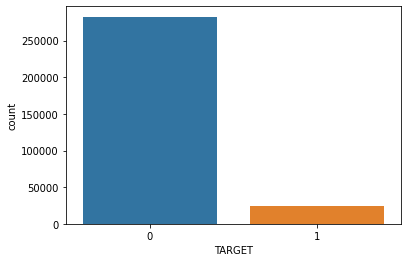

In [16]:
sns.countplot(train['TARGET'])

In [17]:
nan = pd.DataFrame(train.isna().mean().sort_values()[::-1], columns=['mean']).reset_index()

In [18]:
nan['describe'] = nan['index'].apply(lambda x: column_descr[column_descr['Row'] == x]['Description'].values[0])

In [19]:
nan

index      mean  \
0                COMMONAREA_MEDI  0.698723   
1                 COMMONAREA_AVG  0.698723   
2                COMMONAREA_MODE  0.698723   
3       NONLIVINGAPARTMENTS_MODE  0.694330   
4       NONLIVINGAPARTMENTS_MEDI  0.694330   
..                           ...       ...   
117       REG_CITY_NOT_LIVE_CITY  0.000000   
118  LIVE_REGION_NOT_WORK_REGION  0.000000   
119   REG_REGION_NOT_WORK_REGION  0.000000   
120      HOUR_APPR_PROCESS_START  0.000000   
121                   SK_ID_CURR  0.000000   

                                              describe  
0    Normalized information about building where th...  
1    Normalized information about building where th...  
2    Normalized information about building where th...  
3    Normalized information about building where th...  
4    Normalized information about building where th...  
..                                                 ...  
117  Flag if client's permanent address does not ma...  
118  Flag if client's contact address does not matc...  
119  Flag if client's permanent address does not ma...  
120  Approximately at what hour did the client appl...  
121                           ID of loan in our sample  

[122 rows x 3 columns]

In [56]:
nan_test = pd.DataFrame(test.isna().mean().sort_values()[::-1], columns=['mean']).reset_index()

In [57]:
nan

index      mean  \
0                COMMONAREA_MEDI  0.698723   
1                 COMMONAREA_AVG  0.698723   
2                COMMONAREA_MODE  0.698723   
3       NONLIVINGAPARTMENTS_MODE  0.694330   
4       NONLIVINGAPARTMENTS_MEDI  0.694330   
..                           ...       ...   
117       REG_CITY_NOT_LIVE_CITY  0.000000   
118  LIVE_REGION_NOT_WORK_REGION  0.000000   
119   REG_REGION_NOT_WORK_REGION  0.000000   
120      HOUR_APPR_PROCESS_START  0.000000   
121                   SK_ID_CURR  0.000000   

                                              describe  
0    Normalized information about building where th...  
1    Normalized information about building where th...  
2    Normalized information about building where th...  
3    Normalized information about building where th...  
4    Normalized information about building where th...  
..                                                 ...  
117  Flag if client's permanent address does not ma...  
118  Flag if client's contact address does not matc...  
119  Flag if client's permanent address does not ma...  
120  Approximately at what hour did the client appl...  
121                           ID of loan in our sample  

[122 rows x 3 columns]

<AxesSubplot:>

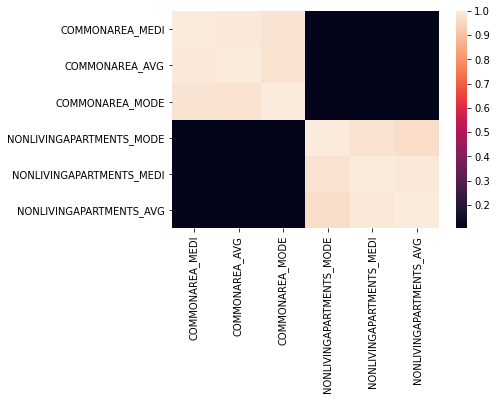

In [20]:

sns.heatmap(train[nan[nan['mean'] > 0.69]['index']].dropna().corr())

In [21]:
num_features = train.select_dtypes(exclude='object').columns
cat_features = train.select_dtypes(include='object').columns
print(num_features.shape, cat_features.shape)

(106,) (16,)


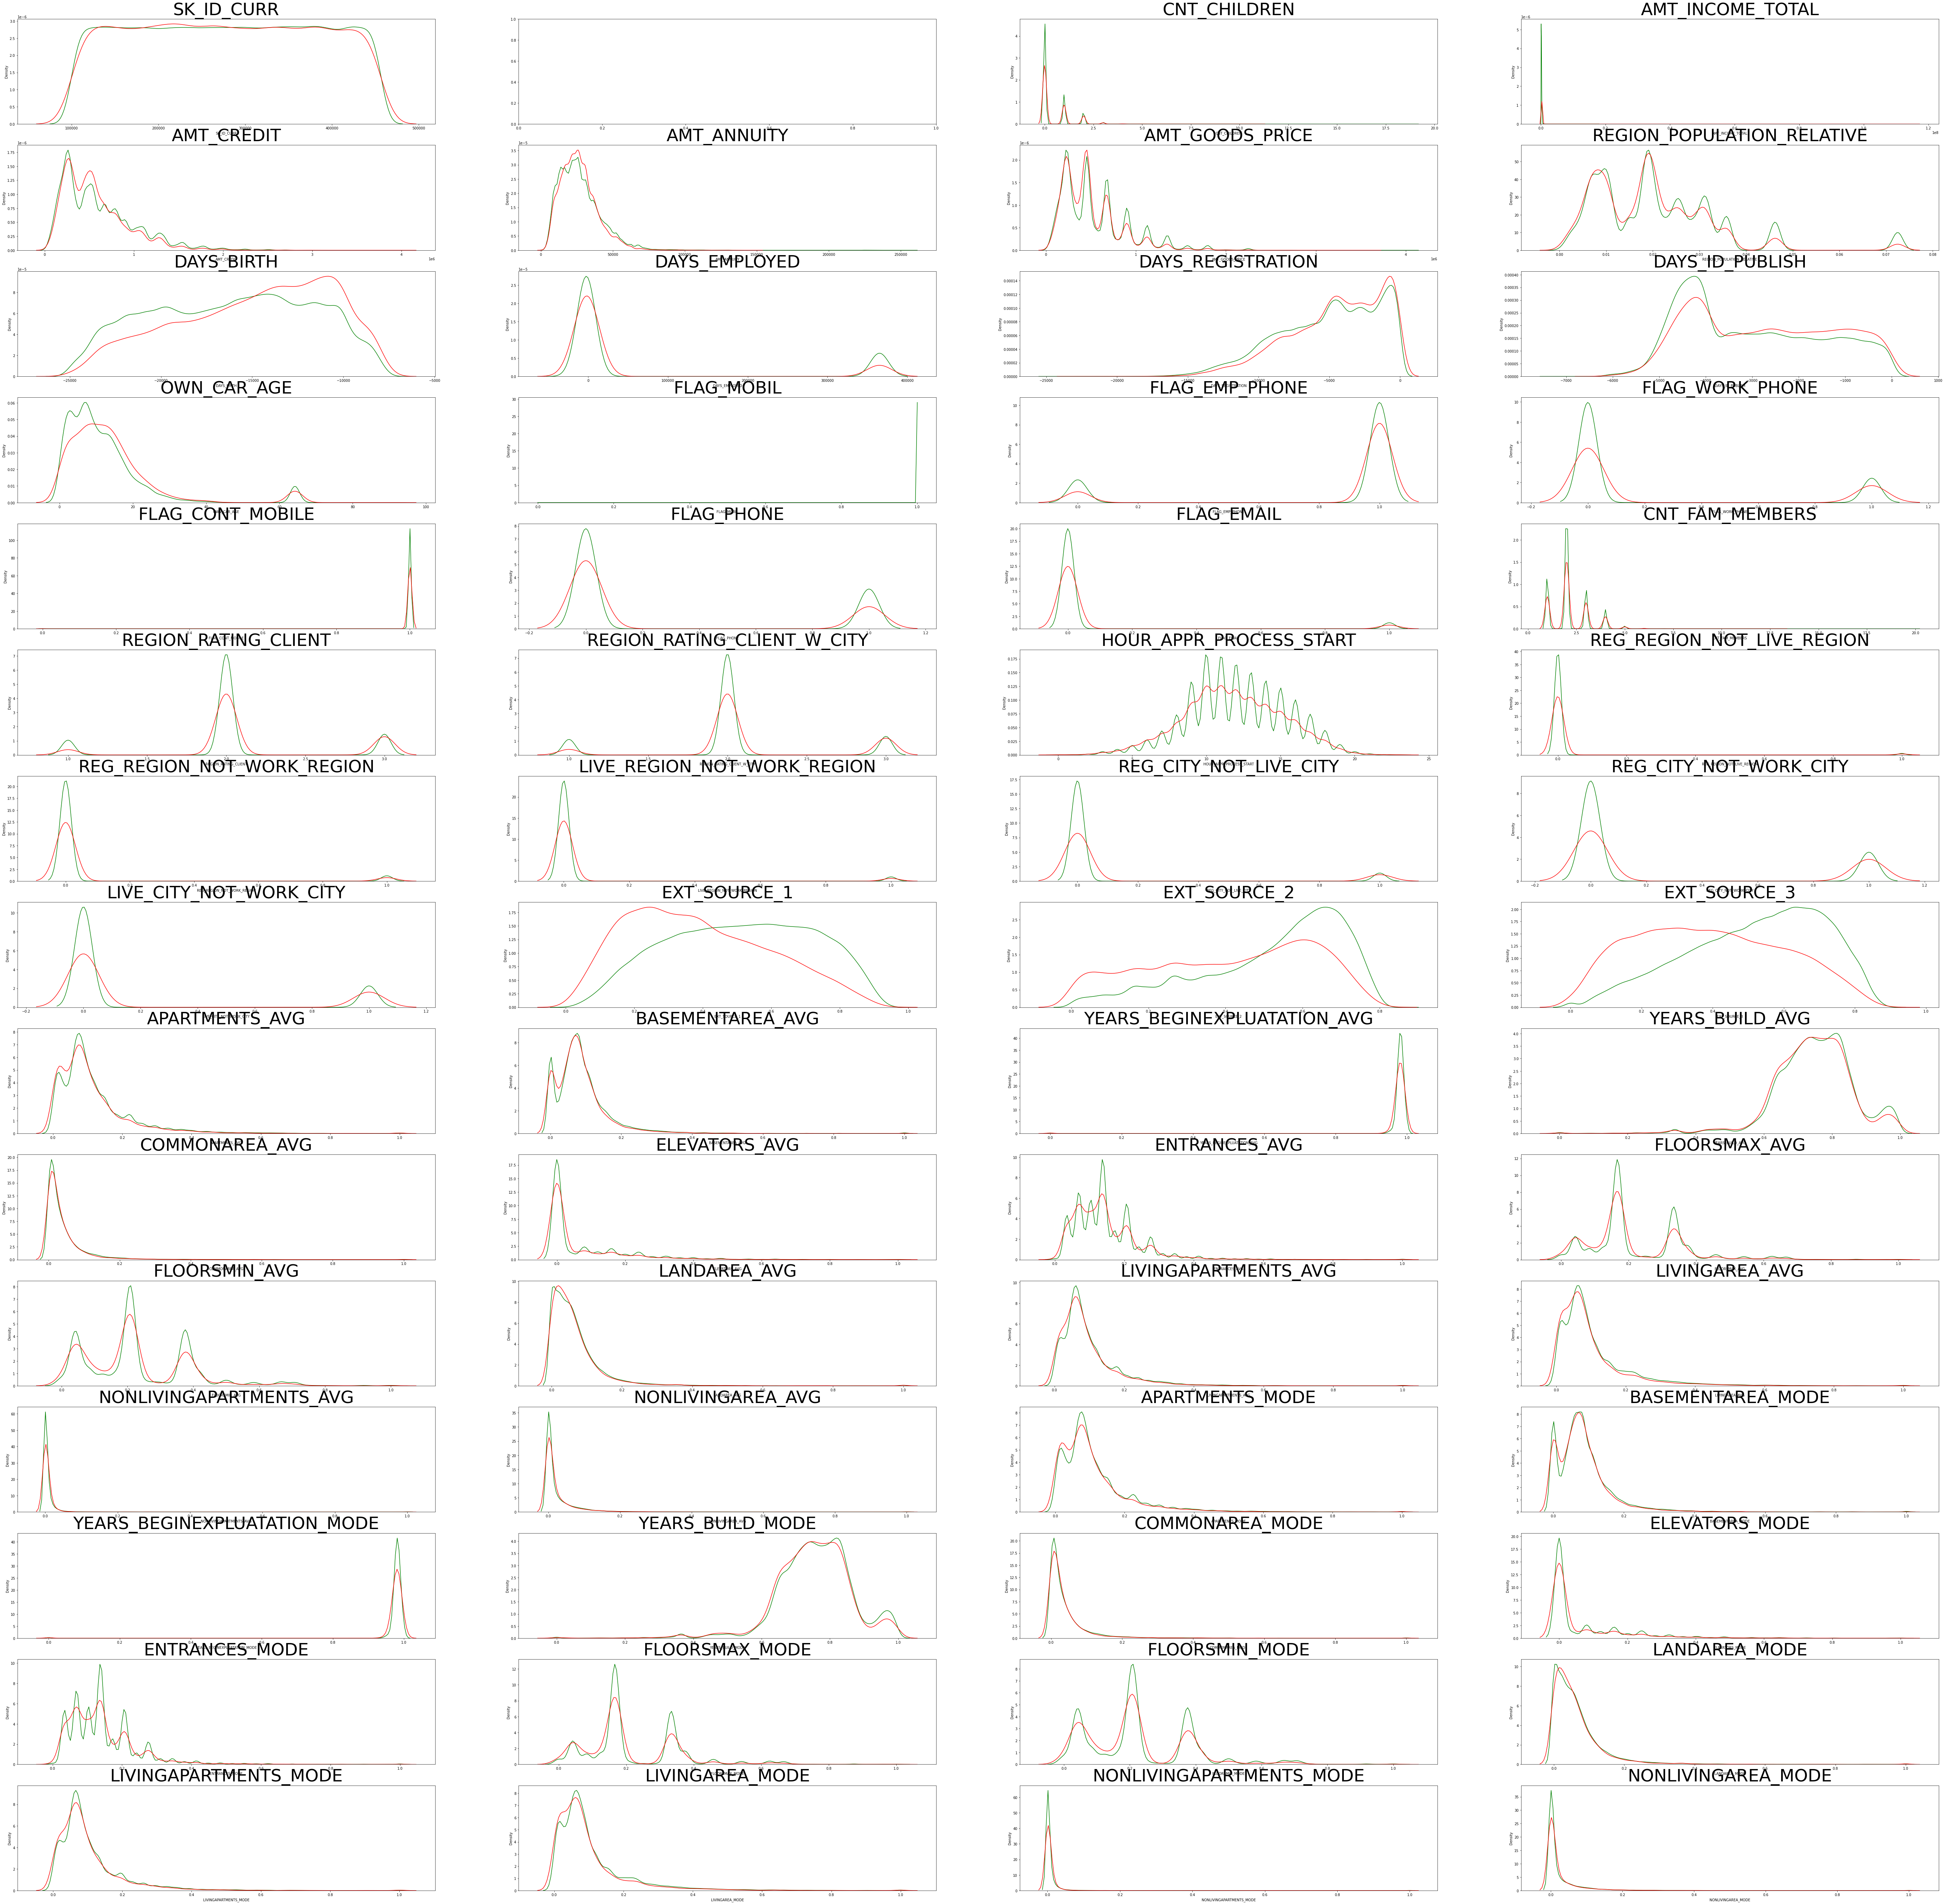

In [28]:
plt.figure(figsize=(100, 100))
for i, j in enumerate(num_features[:60]):
    plt.subplot(15, 4, i + 1)
    kde(train, j)

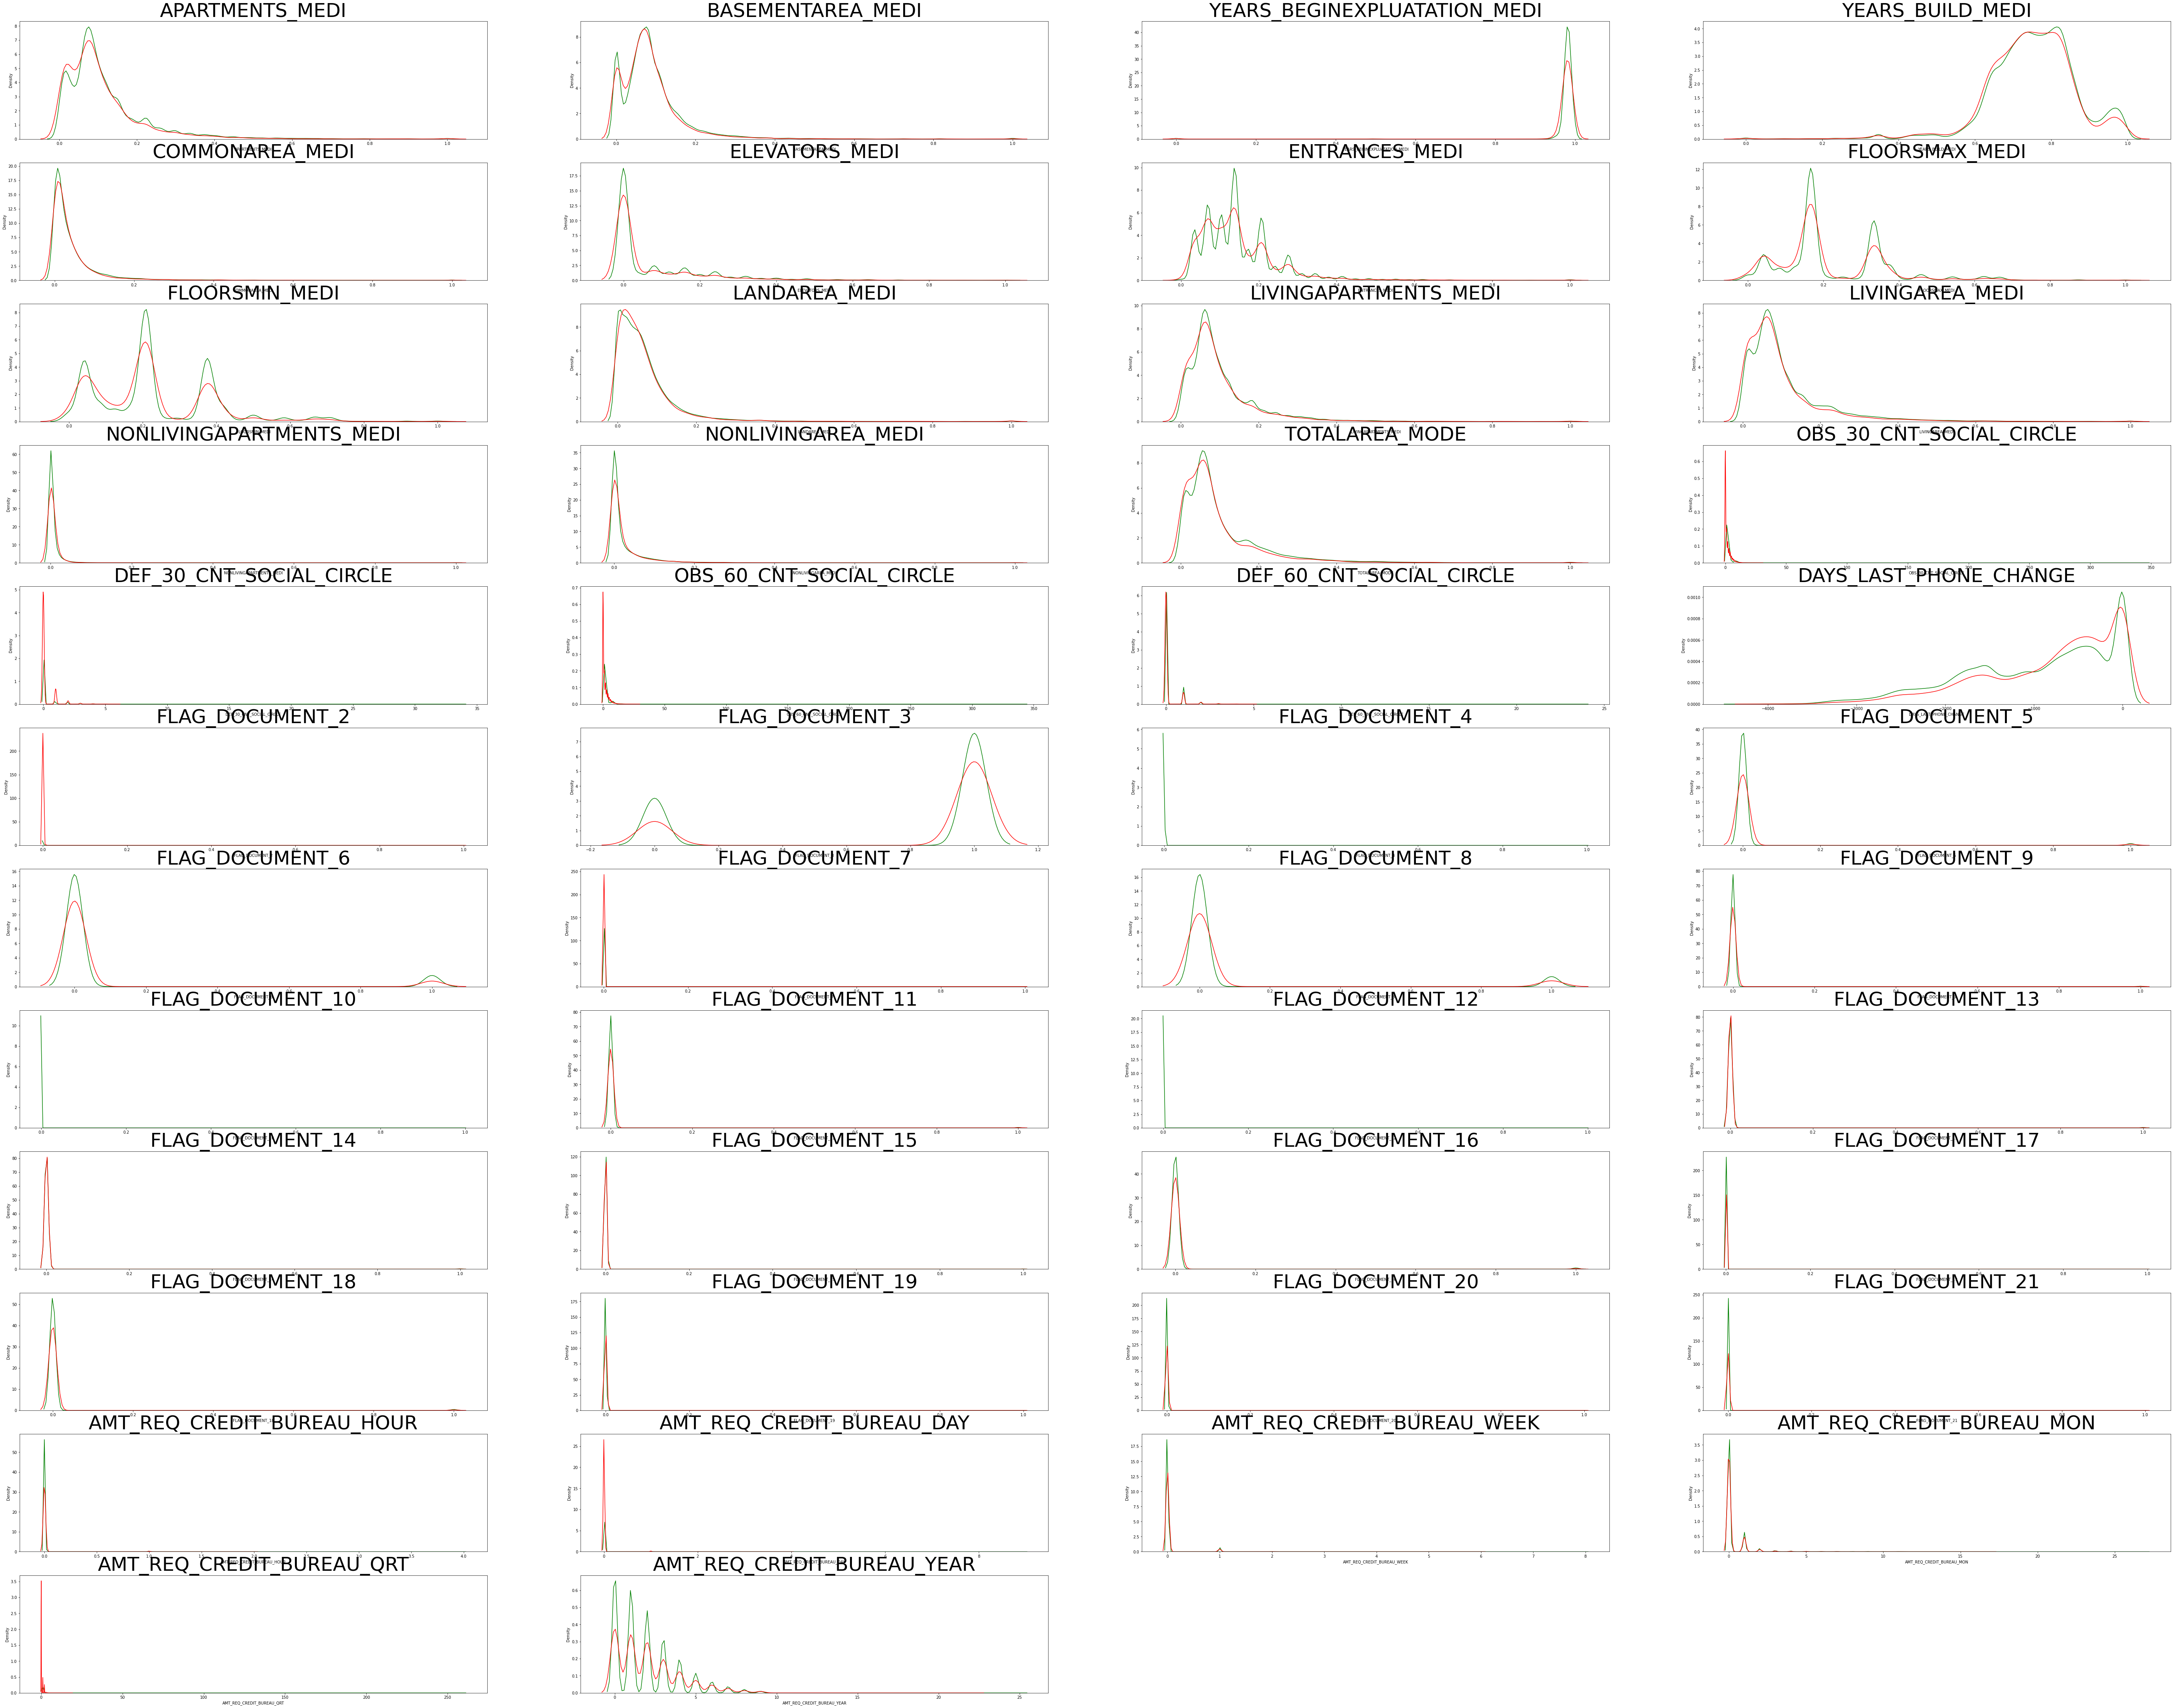

In [29]:
plt.figure(figsize=(100, 100))
for i, j in enumerate(num_features[60:]):
    plt.subplot(15, 4, i + 1)
    kde(train, j)

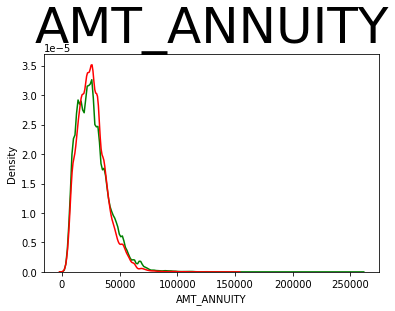

In [33]:
kde(train, 'AMT_ANNUITY')

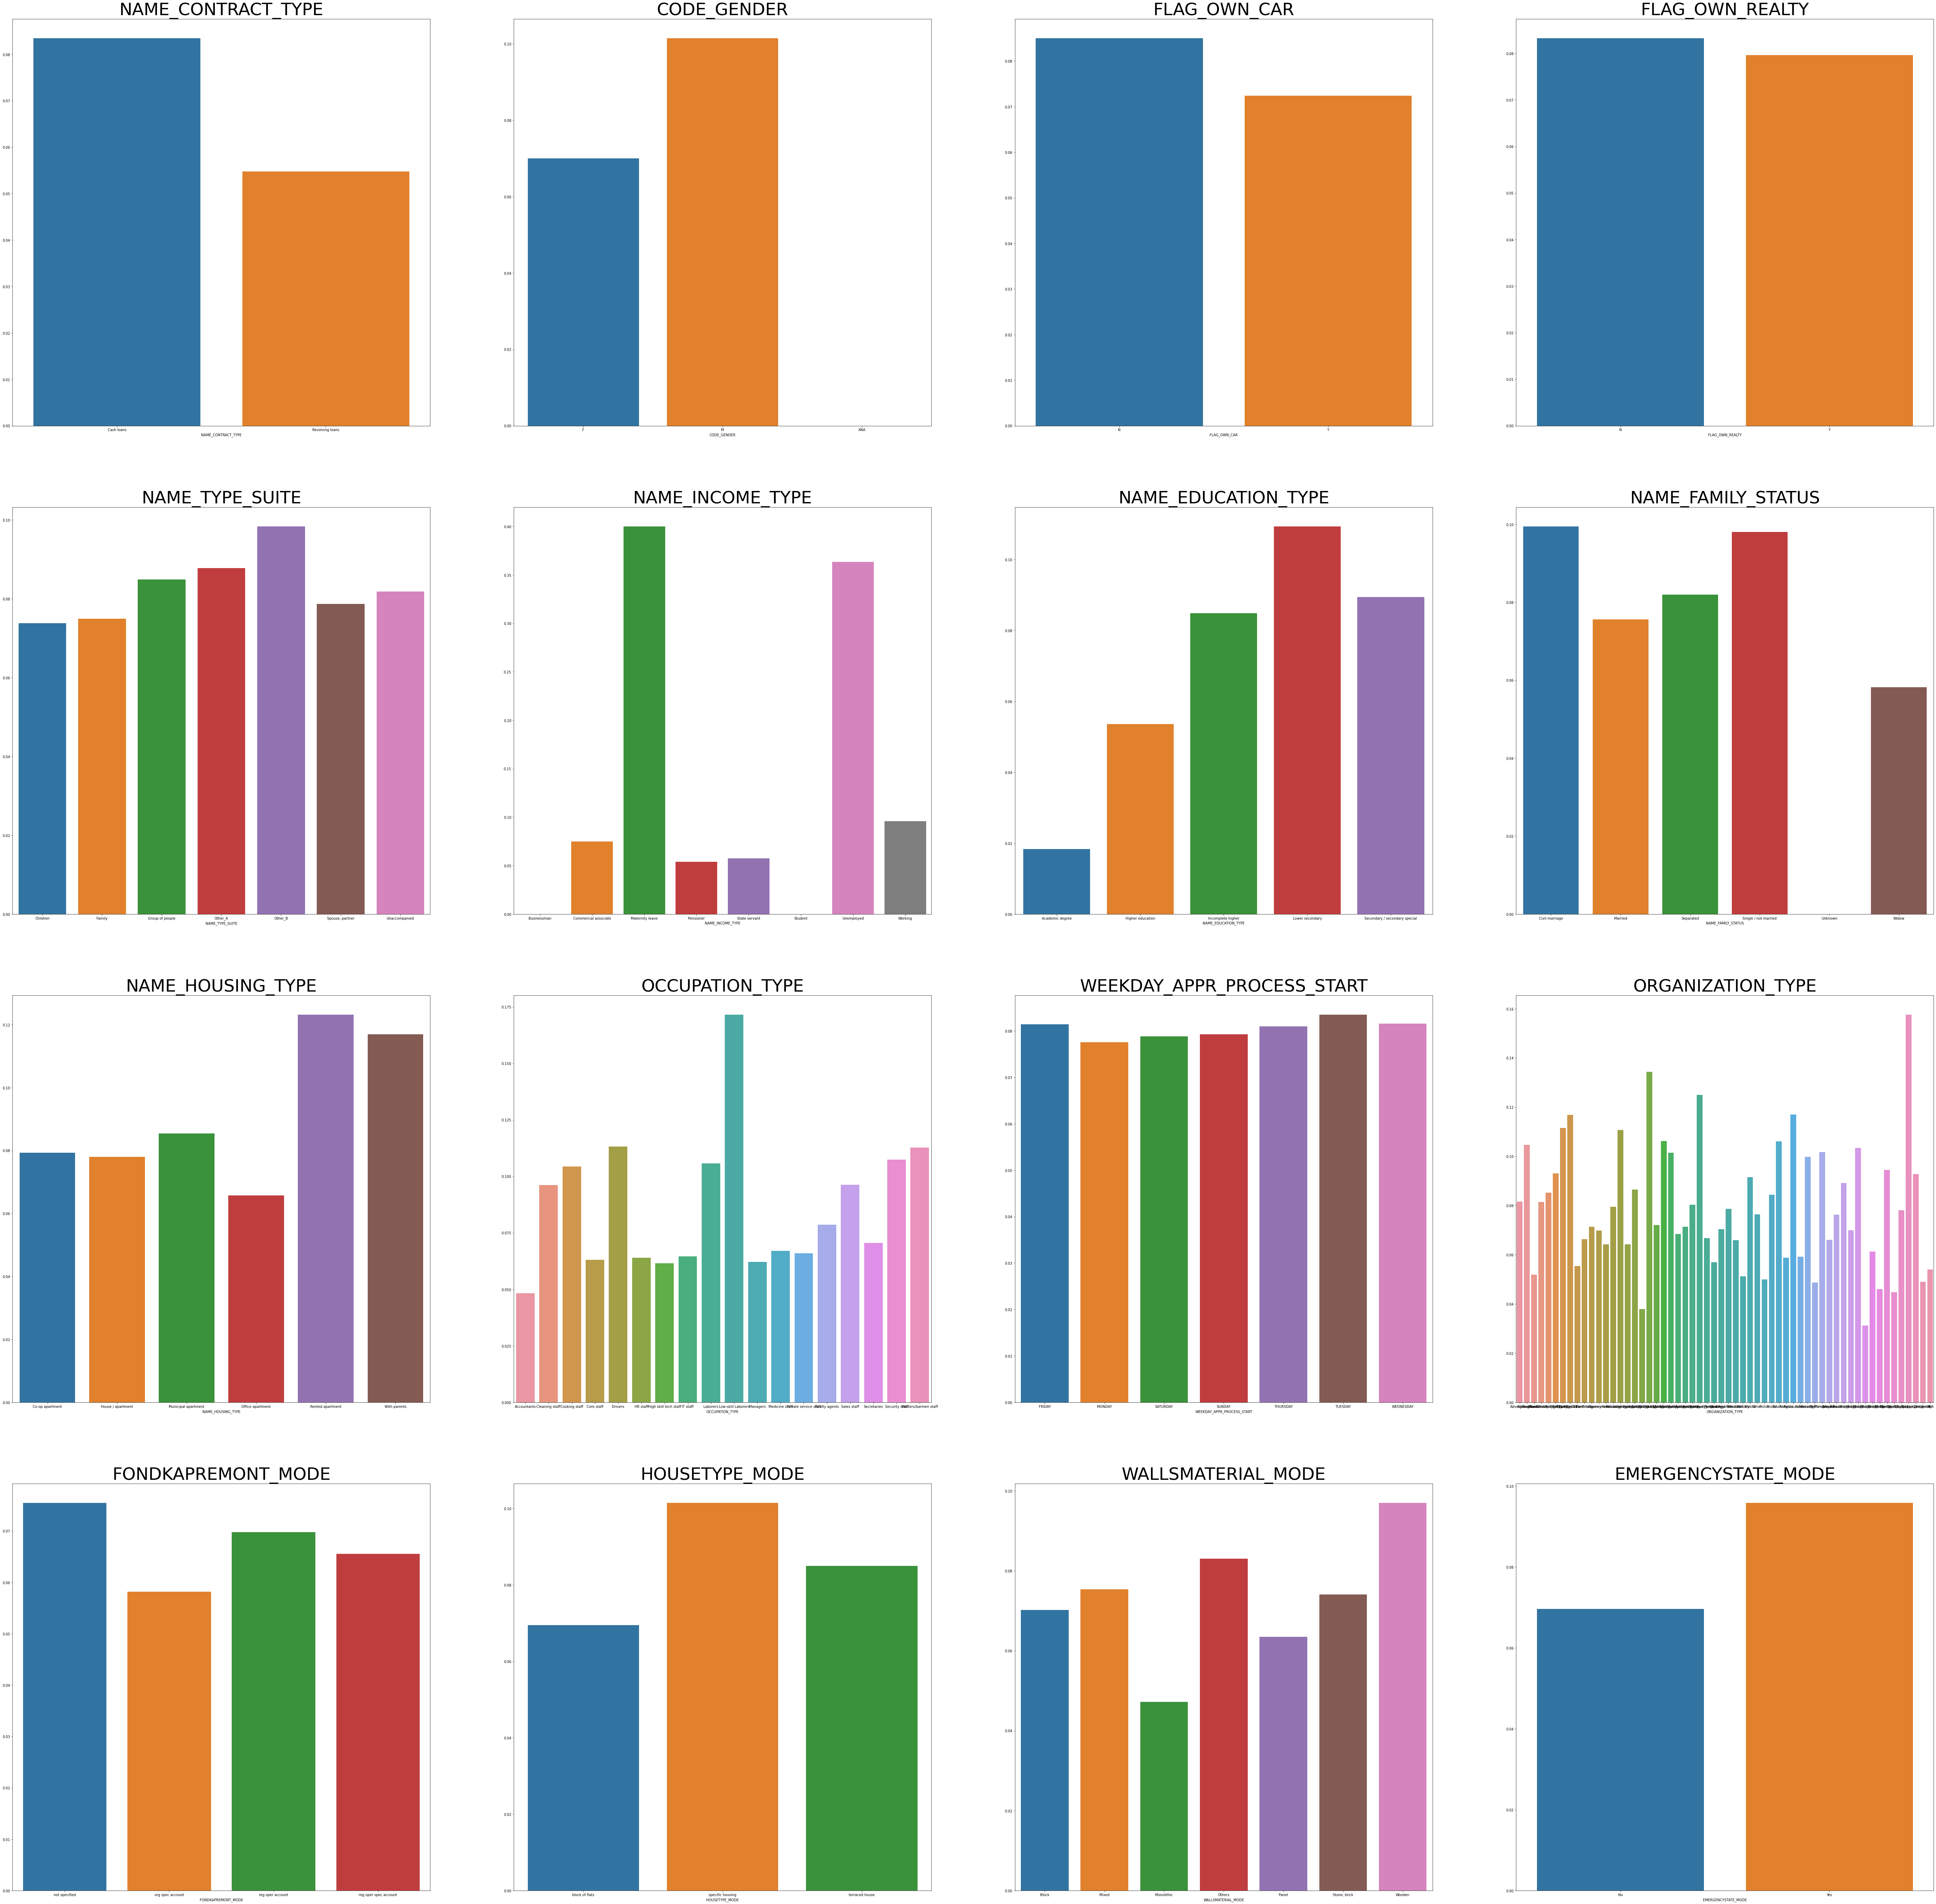

In [34]:
plt.figure(figsize=(100, 100))
for i, j in enumerate(cat_features):
    plt.subplot(4, 4, i + 1)
    bar(train, j)

In [35]:
nan

index      mean  \
0                COMMONAREA_MEDI  0.698723   
1                 COMMONAREA_AVG  0.698723   
2                COMMONAREA_MODE  0.698723   
3       NONLIVINGAPARTMENTS_MODE  0.694330   
4       NONLIVINGAPARTMENTS_MEDI  0.694330   
..                           ...       ...   
117       REG_CITY_NOT_LIVE_CITY  0.000000   
118  LIVE_REGION_NOT_WORK_REGION  0.000000   
119   REG_REGION_NOT_WORK_REGION  0.000000   
120      HOUR_APPR_PROCESS_START  0.000000   
121                   SK_ID_CURR  0.000000   

                                              describe  
0    Normalized information about building where th...  
1    Normalized information about building where th...  
2    Normalized information about building where th...  
3    Normalized information about building where th...  
4    Normalized information about building where th...  
..                                                 ...  
117  Flag if client's permanent address does not ma...  
118  Flag if client's contact address does not matc...  
119  Flag if client's permanent address does not ma...  
120  Approximately at what hour did the client appl...  
121                           ID of loan in our sample  

[122 rows x 3 columns]

In [36]:
nan.iloc[:30]

index      mean  \
0            COMMONAREA_MEDI  0.698723   
1             COMMONAREA_AVG  0.698723   
2            COMMONAREA_MODE  0.698723   
3   NONLIVINGAPARTMENTS_MODE  0.694330   
4   NONLIVINGAPARTMENTS_MEDI  0.694330   
5    NONLIVINGAPARTMENTS_AVG  0.694330   
6         FONDKAPREMONT_MODE  0.683862   
7      LIVINGAPARTMENTS_MEDI  0.683550   
8      LIVINGAPARTMENTS_MODE  0.683550   
9       LIVINGAPARTMENTS_AVG  0.683550   
10            FLOORSMIN_MEDI  0.678486   
11            FLOORSMIN_MODE  0.678486   
12             FLOORSMIN_AVG  0.678486   
13          YEARS_BUILD_MEDI  0.664978   
14           YEARS_BUILD_AVG  0.664978   
15          YEARS_BUILD_MODE  0.664978   
16               OWN_CAR_AGE  0.659908   
17             LANDAREA_MODE  0.593767   
18              LANDAREA_AVG  0.593767   
19             LANDAREA_MEDI  0.593767   
20         BASEMENTAREA_MEDI  0.585160   
21          BASEMENTAREA_AVG  0.585160   
22         BASEMENTAREA_MODE  0.585160   
23              EXT_SOURCE_1  0.563811   
24        NONLIVINGAREA_MEDI  0.551792   
25         NONLIVINGAREA_AVG  0.551792   
26        NONLIVINGAREA_MODE  0.551792   
27            ELEVATORS_MODE  0.532960   
28             ELEVATORS_AVG  0.532960   
29            ELEVATORS_MEDI  0.532960   

                                             describe  
0   Normalized information about building where th...  
1   Normalized information about building where th...  
2   Normalized information about building where th...  
3   Normalized information about building where th...  
4   Normalized information about building where th...  
5   Normalized information about building where th...  
6   Normalized information about building where th...  
7   Normalized information about building where th...  
8   Normalized information about building where th...  
9   Normalized information about building where th...  
10  Normalized information about building where th...  
11  Normalized information about building where th...  
12  Normalized information about building where th...  
13  Normalized information about building where th...  
14  Normalized information about building where th...  
15  Normalized information about building where th...  
16                                Age of client's car  
17  Normalized information about building where th...  
18  Normalized information about building where th...  
19  Normalized information about building where th...  
20  Normalized information about building where th...  
21  Normalized information about building where th...  
22  Normalized information about building where th...  
23         Normalized score from external data source  
24  Normalized information about building where th...  
25  Normalized information about building where th...  
26  Normalized information about building where th...  
27  Normalized information about building where th...  
28  Normalized information about building where th...  
29  Normalized information about building where th...

In [38]:
from sklearn.impute import SimpleImputer

In [71]:
train_enc = encoder(train)
test_enc = encoder(test)
print(train_enc.shape, test_enc.shape)

(307511, 242) (48744, 237)


In [72]:
y_train = train_enc['TARGET']
train_enc, test_enc = train_enc.align(test_enc, join='inner', axis=1)
print(train_enc.shape, test_enc.shape)

(307511, 236) (48744, 236)


In [73]:
impute = SimpleImputer(strategy='median')
train_enc[:] = impute.fit_transform(train_enc)
test_enc[:] = impute.transform(test_enc)
train_enc['CREDIT_INCOME_PERCENT'] = train_enc['AMT_CREDIT'] / train_enc['AMT_INCOME_TOTAL']
train_enc['ANNUITY_INCOME_PERCENT'] = train_enc['AMT_ANNUITY'] / train_enc['AMT_INCOME_TOTAL']
train_enc['CREDIT_TERM'] = train_enc['AMT_ANNUITY'] / train_enc['AMT_CREDIT']
train_enc['DAYS_EMPLOYED_PERCENT'] = train_enc['DAYS_EMPLOYED'] / train_enc['DAYS_BIRTH']
test_enc['CREDIT_INCOME_PERCENT'] = test_enc['AMT_CREDIT'] / test_enc['AMT_INCOME_TOTAL']
test_enc['ANNUITY_INCOME_PERCENT'] = test_enc['AMT_ANNUITY'] / test_enc['AMT_INCOME_TOTAL']
test_enc['CREDIT_TERM'] = test_enc['AMT_ANNUITY'] / test_enc['AMT_CREDIT']
test_enc['DAYS_EMPLOYED_PERCENT'] = test_enc['DAYS_EMPLOYED'] / test_enc['DAYS_BIRTH']
train_enc['TARGET'] = y_train

In [74]:
train_hot, valid_hot = train_test_split(train_enc, train_size=0.3, stratify=train_enc['TARGET'], random_state=11)
X_train_hot = train_hot.drop(['SK_ID_CURR', 'TARGET'], 1)
y_train = train_hot['TARGET']
X_valid_hot = valid_hot.drop(['SK_ID_CURR', 'TARGET'], 1)
y_valid = valid_hot['TARGET']

In [75]:
xgb = xgboost.XGBClassifier(n_estimators=600, max_depth=6, learning_rate=0.03, random_state=11, subsample=0.85, n_jobs=-1)
xgb.fit(X_train_hot, y_train, eval_set=[(X_valid_hot, y_valid)], eval_metric='auc', early_stopping_rounds=100, verbose=True)

[0]	validation_0-auc:0.70728
[1]	validation_0-auc:0.71171
[2]	validation_0-auc:0.71241
[3]	validation_0-auc:0.71445
[4]	validation_0-auc:0.71476
[5]	validation_0-auc:0.71575
[6]	validation_0-auc:0.71714
[7]	validation_0-auc:0.71749
[8]	validation_0-auc:0.71744
[9]	validation_0-auc:0.71848
[10]	validation_0-auc:0.71915
[11]	validation_0-auc:0.71914
[12]	validation_0-auc:0.71925
[13]	validation_0-auc:0.71971
[14]	validation_0-auc:0.72006
[15]	validation_0-auc:0.72059
[16]	validation_0-auc:0.72093
[17]	validation_0-auc:0.72149
[18]	validation_0-auc:0.72204
[19]	validation_0-auc:0.72212
[20]	validation_0-auc:0.72235
[21]	validation_0-auc:0.72248
[22]	validation_0-auc:0.72275
[23]	validation_0-auc:0.72316
[24]	validation_0-auc:0.72351
[25]	validation_0-auc:0.72349
[26]	validation_0-auc:0.72394
[27]	validation_0-auc:0.72403
[28]	validation_0-auc:0.72408
[29]	validation_0-auc:0.72447
[30]	validation_0-auc:0.72462
[31]	validation_0-auc:0.72492
[32]	validation_0-auc:0.72500
[33]	validation_0-au

[268]	validation_0-auc:0.75708
[269]	validation_0-auc:0.75714
[270]	validation_0-auc:0.75716
[271]	validation_0-auc:0.75721
[272]	validation_0-auc:0.75719
[273]	validation_0-auc:0.75720
[274]	validation_0-auc:0.75724
[275]	validation_0-auc:0.75731
[276]	validation_0-auc:0.75733
[277]	validation_0-auc:0.75733
[278]	validation_0-auc:0.75738
[279]	validation_0-auc:0.75738
[280]	validation_0-auc:0.75744
[281]	validation_0-auc:0.75743
[282]	validation_0-auc:0.75744
[283]	validation_0-auc:0.75742
[284]	validation_0-auc:0.75742
[285]	validation_0-auc:0.75742
[286]	validation_0-auc:0.75743
[287]	validation_0-auc:0.75743
[288]	validation_0-auc:0.75747
[289]	validation_0-auc:0.75750
[290]	validation_0-auc:0.75751
[291]	validation_0-auc:0.75753
[292]	validation_0-auc:0.75759
[293]	validation_0-auc:0.75771
[294]	validation_0-auc:0.75769
[295]	validation_0-auc:0.75774
[296]	validation_0-auc:0.75772
[297]	validation_0-auc:0.75773
[298]	validation_0-auc:0.75784
[299]	validation_0-auc:0.75787
[300]	va

[533]	validation_0-auc:0.75994
[534]	validation_0-auc:0.75994
[535]	validation_0-auc:0.75992
[536]	validation_0-auc:0.75991
[537]	validation_0-auc:0.75991
[538]	validation_0-auc:0.75990
[539]	validation_0-auc:0.75991
[540]	validation_0-auc:0.75990
[541]	validation_0-auc:0.75990
[542]	validation_0-auc:0.75994


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=-1, num_parallel_tree=1, random_state=11,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [76]:
xgb.best_score

0.76015

<AxesSubplot:xlabel='important', ylabel='feature'>

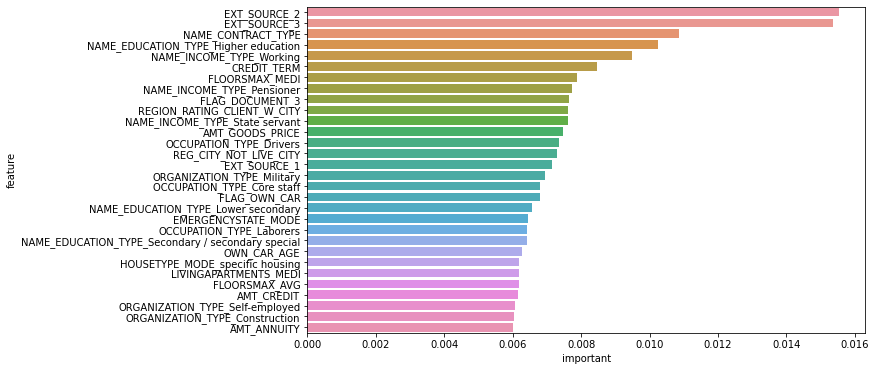

In [77]:
plt.figure(figsize = (10, 6))
feature_imp = pd.DataFrame({'important': xgb.feature_importances_, 'feature': X_train_hot.columns}).sort_values('important', ascending=False)
sns.barplot(feature_imp['important'].iloc[:30], feature_imp['feature'][:30], orient='h')

In [78]:
train_enc.to_csv('train.csv', index=False)

In [80]:
test_enc.to_csv('test.csv', index=False)

In [81]:
train_hot, valid_hot = train_test_split(train_enc.drop(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT'], 1), train_size=0.3, stratify=train_enc['TARGET'], random_state=11)
X_train_hot = train_hot.drop(['SK_ID_CURR', 'TARGET'], 1)
y_train = train_hot['TARGET']
X_valid_hot = valid_hot.drop(['SK_ID_CURR', 'TARGET'], 1)
y_valid = valid_hot['TARGET']

In [82]:
xgb = xgboost.XGBClassifier(n_estimators=600, max_depth=6, learning_rate=0.03, random_state=11, subsample=0.85, n_jobs=-1)
xgb.fit(X_train_hot, y_train, eval_set=[(X_valid_hot, y_valid)], eval_metric='auc', early_stopping_rounds=100, verbose=True)

[0]	validation_0-auc:0.70759
[1]	validation_0-auc:0.71264
[2]	validation_0-auc:0.71324
[3]	validation_0-auc:0.71460
[4]	validation_0-auc:0.71510
[5]	validation_0-auc:0.71613
[6]	validation_0-auc:0.71737
[7]	validation_0-auc:0.71809
[8]	validation_0-auc:0.71807
[9]	validation_0-auc:0.71869
[10]	validation_0-auc:0.71931
[11]	validation_0-auc:0.71924
[12]	validation_0-auc:0.71930
[13]	validation_0-auc:0.71985
[14]	validation_0-auc:0.72016
[15]	validation_0-auc:0.72071
[16]	validation_0-auc:0.72092
[17]	validation_0-auc:0.72146
[18]	validation_0-auc:0.72179
[19]	validation_0-auc:0.72191
[20]	validation_0-auc:0.72213
[21]	validation_0-auc:0.72218
[22]	validation_0-auc:0.72238
[23]	validation_0-auc:0.72277
[24]	validation_0-auc:0.72307
[25]	validation_0-auc:0.72297
[26]	validation_0-auc:0.72319
[27]	validation_0-auc:0.72322
[28]	validation_0-auc:0.72326
[29]	validation_0-auc:0.72369
[30]	validation_0-auc:0.72399
[31]	validation_0-auc:0.72426
[32]	validation_0-auc:0.72432
[33]	validation_0-au

[268]	validation_0-auc:0.75103
[269]	validation_0-auc:0.75103
[270]	validation_0-auc:0.75104
[271]	validation_0-auc:0.75114
[272]	validation_0-auc:0.75116
[273]	validation_0-auc:0.75118
[274]	validation_0-auc:0.75123
[275]	validation_0-auc:0.75135
[276]	validation_0-auc:0.75137
[277]	validation_0-auc:0.75139
[278]	validation_0-auc:0.75145
[279]	validation_0-auc:0.75149
[280]	validation_0-auc:0.75152
[281]	validation_0-auc:0.75158
[282]	validation_0-auc:0.75154
[283]	validation_0-auc:0.75157
[284]	validation_0-auc:0.75161
[285]	validation_0-auc:0.75158
[286]	validation_0-auc:0.75157
[287]	validation_0-auc:0.75160
[288]	validation_0-auc:0.75161
[289]	validation_0-auc:0.75164
[290]	validation_0-auc:0.75164
[291]	validation_0-auc:0.75165
[292]	validation_0-auc:0.75166
[293]	validation_0-auc:0.75170
[294]	validation_0-auc:0.75171
[295]	validation_0-auc:0.75170
[296]	validation_0-auc:0.75173
[297]	validation_0-auc:0.75172
[298]	validation_0-auc:0.75171
[299]	validation_0-auc:0.75172
[300]	va

[533]	validation_0-auc:0.75301
[534]	validation_0-auc:0.75301
[535]	validation_0-auc:0.75298
[536]	validation_0-auc:0.75299
[537]	validation_0-auc:0.75300
[538]	validation_0-auc:0.75299
[539]	validation_0-auc:0.75297
[540]	validation_0-auc:0.75296
[541]	validation_0-auc:0.75299
[542]	validation_0-auc:0.75303
[543]	validation_0-auc:0.75302
[544]	validation_0-auc:0.75300
[545]	validation_0-auc:0.75300
[546]	validation_0-auc:0.75300
[547]	validation_0-auc:0.75299
[548]	validation_0-auc:0.75298
[549]	validation_0-auc:0.75301
[550]	validation_0-auc:0.75297
[551]	validation_0-auc:0.75295
[552]	validation_0-auc:0.75294
[553]	validation_0-auc:0.75294
[554]	validation_0-auc:0.75292
[555]	validation_0-auc:0.75293
[556]	validation_0-auc:0.75290
[557]	validation_0-auc:0.75286
[558]	validation_0-auc:0.75287
[559]	validation_0-auc:0.75287
[560]	validation_0-auc:0.75288
[561]	validation_0-auc:0.75290
[562]	validation_0-auc:0.75291
[563]	validation_0-auc:0.75291
[564]	validation_0-auc:0.75289
[565]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=-1, num_parallel_tree=1, random_state=11,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.85,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [83]:
xgb.best_score

0.753226